In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dataframe_image as dfi
from datetime import datetime
import itertools
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import xarray as xr
import regionmask
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from collections import OrderedDict
import sys
from sklearn.preprocessing import MinMaxScaler

## DATA

### Climate: UEA CRU TS4.07 (1901-2022)

In [47]:
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.pre.dat.nc"
file2 = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/cru_ts4.07.1901.2022.tmx.dat.nc"

file_paths_list =[file,file2]
monthly_forecast=xr.Dataset()

for file in file_paths_list:
        monthly_forecast = xr.merge([monthly_forecast,xr.open_mfdataset(file)], compat='override')

### Conflict events: ACLED

In [48]:
file = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/ACLED_1997-01-01-2023-07-18_Somalia.csv"
df = pd.read_csv(file)

### Administrative boundaries of Somalia

In [49]:
path = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/som_adm_ocha_itos_20230308_shp/som_admbnda_adm1_ocha_20230308.shp"
states_gdf = gpd.read_file(path) 

In [50]:
dist = pd.read_csv("/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som.csv")
dist
#square all the values in the dataframe
dist_2 = dist**2
dist_2.to_csv("/home/sara/Documenti/GitHub/Climate-and-conflict/csv/dist_som_2.csv")
dist

,Awdal,Bakool,Banadir,Bari,Bay,Galgaduud,Gedo,Hiraan,Lower Juba,Lower Shabelle,Middle Juba,Middle Shabelle,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi Galbeed
0,0.000000,517.218397,711.218429,742.268579,640.923618,572.573763,647.779719,557.628353,877.622654,704.772589,767.888304,665.735780,623.026648,644.204898,479.077647,482.231520,285.842059,142.406810
1,517.218397,0.000000,230.459285,816.895990,132.307154,321.315006,243.673933,168.867628,412.725620,189.058684,288.603501,247.327023,496.059303,627.452326,629.170199,545.689072,434.529594,457.507691
2,711.218429,230.459285,0.000000,800.859247,205.431474,280.467736,382.153544,166.209334,428.198798,117.533030,322.263281,102.187766,450.301150,602.608417,680.199108,581.253671,549.368317,620.835581
3,742.268579,816.895990,800.859247,0.000000,922.365372,525.166365,1059.760467,679.290707,1205.171808,894.879743,1083.283462,698.700816,350.906305,198.324664,263.233962,291.243375,487.812691,611.349610
4,640.923618,132.307154,205.431474,922.365372,0.000000,405.005883,177.231848,245.061573,287.515421,103.302763,163.016339,273.493275,585.777980,727.665054,751.140158,662.890375,565.184220,588.829360
5,572.573763,321.315006,280.467736,525.166365,405.005883,0.000000,560.717080,160.405703,681.934687,369.723309,562.011929,180.629157,180.875755,327.339256,406.515437,305.492225,330.048651,446.206223
6,647.779719,243.673933,382.153544,1059.760467,177.231848,560.717080,0.000000,401.896864,233.895467,272.246943,150.961183,448.135556,738.324347,871.116292,862.026788,784.007249,649.637227,634.425146
7,557.628353,168.867628,166.209334,679.290707,245.061573,160.405703,401.896864,0.000000,525.957400,222.465475,404.151854,109.874316,340.858891,483.338517,527.736747,432.597087,383.303369,458.229602
8,877.622654,412.725620,428.198798,1205.171808,287.515421,681.934687,233.895467,525.957400,0.000000,316.563005,124.705721,524.096193,861.996502,1008.564967,1038.533550,950.264966,846.358294,851.927825
9,704.772589,189.058684,117.533030,894.879743,103.302763,369.723309,272.246943,222.465475,316.563005,0.000000,205.554511,207.789490,547.896999,697.011142,749.759121,655.062560,588.721636,635.143585


### Displacements : UNHCR

In [51]:
df_disp = pd.read_excel(r"/home/sara/Documenti/GitHub/Climate-and-conflict/displacements/UNHCR-PRMN-Displacement-Dataset - Somalia.xlsx")

### Population density Data

In [52]:
asc = r"/home/sara/Documenti/GitHub/Climate-and-conflict/Datasets/gpw_v4_admin_unit_center_points_population_estimates_rev11_som.csv"
population_density = pd.read_csv(asc)

# Data manipulation

## Climate data manipulation

In [53]:
#Limit the lat-lon and time

def get_aoi(shp, world=True):
    lon_lat = {}
    # Get lat min, max
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    lon_lat["lon"] = aoi_lon
    lon_lat["lat"] = aoi_lat
    return lon_lat

bounds = get_aoi(states_gdf)

In [54]:
start_date = '1901-01-01'
end_date = '2022-12-31'

region = monthly_forecast[["pre",'tmx']].sel(
    time=slice(start_date, end_date),
    lon=slice(bounds["lon"][0], bounds["lon"][1]),
    lat=slice(bounds["lat"][0], bounds["lat"][1]))

In [55]:
region_mask = regionmask.mask_3D_geopandas(states_gdf,
                                         monthly_forecast.lon,
                                         monthly_forecast.lat)

temp_pre = region.where(region_mask)
temp_pre = temp_pre.groupby("time").mean(["lat", "lon"]).to_dataframe().reset_index()

In [56]:
replacement_dict = {0  :  'Awdal',
                    1  :  'Bakool',
                    2  :  'Banadir',
                    3  :  'Bari',
                    4  :  'Bay',
                    5  :  'Galgaduud',
                    6  :  'Gedo',
                    7  :  'Hiraan',
                    8  :  'Lower_Juba',
                    9  :  'Lower_Shabelle',
                    10 :  'Middle_Juba',
                    11 :  'Middle_Shabelle',
                    12 :  'Mudug',
                    13 :  'Nugaal',
                    14 :  'Sanaag',
                    15 :  'Sool',
                    16 :  'Togdheer',
                    17 :  'Woqooyi_Galbeed'}

temp_pre['admin1'] = temp_pre['region'].replace(replacement_dict)
df['admin1'] = df['admin1'].str.replace(' ', '_')
temp_pre.drop('region', axis=1, inplace=True)

In [57]:
# Add Banadir region with tmx and pre as mean of the neighbouring regions
district1 = 'Lower_Shabelle'  
district2 = 'Middle_Shabelle'  

# Calculate the mean tmx and pre for the neighboring districts
mean_t = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['tmx'].mean()
mean_p = temp_pre[(temp_pre['admin1']==district1) | (temp_pre['admin1']==district2)].groupby('time')['pre'].mean()
new_data = pd.DataFrame({ 'admin1': 'Banadir', 'tmx': mean_t, 'pre': mean_p}).reset_index()

# Append the new DataFrame to the original DataFrame
temp_pre_m = pd.concat([temp_pre, new_data])
temp_pre = temp_pre_m.sort_values(by=['time', 'admin1'], ascending=[True, True]).reset_index(drop=True)

In [58]:
# Only keep month and year in time column 
temp_pre['time'] = pd.to_datetime(temp_pre['time']).dt.strftime('%Y-%m-%d')
temp_pre['month'] = temp_pre['time'].str[5:7]
temp_pre['month_year'] = temp_pre['time'].str[:7]
temp_pre = temp_pre[['month_year','admin1','tmx','pre']]
temp_pre = temp_pre.rename(columns={'month_year':'time'})

## Conflict data manipulation

In [59]:
# Modify event_date column to datetime

df['event_date'] = pd.to_datetime(df['event_date'])
df = df.set_index('event_date') 

conflict = df.groupby([pd.Grouper(freq='M'),"admin1"]).count()
conflict.reset_index(level=[0, 1], inplace=True)
conflict = conflict[['event_date','admin1','year']].rename(columns={'year': 'conflicts','event_date': 'time'})

# Aggregate the datetime objects by month
conf = conflict.groupby([pd.Grouper(key='time', freq='M'),'admin1'])['conflicts'].sum().to_frame()

In [60]:
# Reindex the DataFrame with all dates and districts and fill missing values with 0

dates = conf.index.get_level_values('time').unique()
districts = conf.index.get_level_values('admin1').unique()
all_combinations = pd.MultiIndex.from_product([dates, districts], names=['time', 'admin1'])

conflicts = conf.reindex(all_combinations, fill_value=0).reset_index()    
conflicts = conflicts.sort_values(by=['time', 'admin1'], ascending=[True, True])
conflicts.reset_index(drop=True, inplace=True)
conflicts['time'] = conflicts['time'].dt.strftime('%Y-%m').values

# Merge the two DataFrames temp_pre and conflicts
df_2016 = pd.merge(temp_pre, conflicts, on=['time','admin1'], how='outer')

## Displacements data manipulation

In [61]:
df_disp = df_disp[(df_disp['Reason']=='Drought related')]
df_disp['Current (Arrival) Region'] = df_disp['Current (Arrival) Region'].str.replace(' ', '_')
df_disp['Previous (Departure) Region'] = df_disp['Previous (Departure) Region'].str.replace(' ', '_')

In [62]:
v= df_disp["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]

for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i]))
    
df_disp.insert(loc=3, column='date_timestamp', value=q)
df_disp = df_disp.sort_values("date_timestamp")

df_disp['Month End'] = pd.to_datetime(df_disp['Month End'], dayfirst=True)

In [63]:
aggregated_data = df_disp.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()

# Get the unique values of 'Month End' and 'Previous (Departure) Region' 
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()

all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])

# Reindex the aggregated_data DataFrame with 'all_combinations'
disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index()   

In [64]:
disp_data

,time,Previous (Departure) Region,Current (Arrival) Region,Number of Individuals
0,2016-01-31,Bakool,Bakool,0
1,2016-01-31,Bakool,Banadir,0
2,2016-01-31,Bakool,Bari,0
3,2016-01-31,Bakool,Bay,14
4,2016-01-31,Bakool,Galgaduud,0
...,...,...,...,...
29803,2023-08-31,Awdal,Sanaag,0
29804,2023-08-31,Awdal,Sool,0
29805,2023-08-31,Awdal,Togdheer,0
29806,2023-08-31,Awdal,Woqooyi_Galbeed,0


In [65]:
disp_matxs = disp_data.pivot_table(index=['time','Current (Arrival) Region'], columns='Previous (Departure) Region', values='Number of Individuals', aggfunc='sum').reset_index()
disp_matxs = disp_matxs.rename(columns={'Current (Arrival) Region': 'admin1'})

#remove the day from the date
disp_matxs['time'] = disp_matxs['time'].map(lambda x: x.strftime('%Y-%m'))
#disp_matxs = disp_matxs.drop(columns=['time'])
#temp_pre_c['yr_mth'] = pd.to_datetime(temp_pre_c['time'], format='%Y-%m', dayfirst=True).map(lambda x: x.strftime('%Y-%m'))

#df_2016 = df_2016.rename(columns={'time': 'yr_mth'})
df_merged_d = pd.merge(df_2016, disp_matxs, on=['time', 'admin1'], how='outer')

In [66]:
df_merged_d

,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,Bay,Galgaduud,Gedo,Hiraan,Lower_Juba,Lower_Shabelle,Middle_Juba,Middle_Shabelle,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi_Galbeed
0,1901-01,Awdal,29.000000,7.175000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1901-01,Bakool,33.437504,1.612500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1901-01,Banadir,32.549999,6.130000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1901-01,Bari,28.533331,4.045833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1901-01,Bay,33.478569,2.664286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26491,2023-08,Nugaal,NaN,NaN,NaN,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,450.0,0.0,7.0,0.0,0.0
26492,2023-08,Sanaag,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26493,2023-08,Sool,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0
26494,2023-08,Togdheer,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,266.0,0.0


In [67]:
#add a column with the sum of the displacements
df_merged_d['sum_disp'] = df_merged_d.iloc[:, -18:].sum(axis=1)

In [68]:
#df_merged.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4c_disp_d.csv", index=False)

## Compute TA, PA, DL

In [69]:
# Split the dataframe into regions

reg=[]
for admin in df_merged_d['admin1'].unique():
    a = df_merged_d[df_merged_d['admin1']==admin].reset_index(drop=True)
    reg.append(a)

In [70]:
#print all rows
pd.set_option('display.max_columns', None)
reg[0]

,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,Bay,Galgaduud,Gedo,Hiraan,Lower_Juba,Lower_Shabelle,Middle_Juba,Middle_Shabelle,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi_Galbeed,sum_disp
0,1901-01,Awdal,29.000000,7.175000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1901-02,Awdal,29.625000,29.550001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1901-03,Awdal,30.850000,19.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1901-04,Awdal,31.824999,38.350002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1901-05,Awdal,34.025002,0.775000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,2023-04,Awdal,NaN,NaN,0.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0
1468,2023-05,Awdal,NaN,NaN,3.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0
1469,2023-06,Awdal,NaN,NaN,0.0,278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,278.0
1470,2023-07,Awdal,NaN,NaN,0.0,798.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,798.0


In [71]:
# Calculate the TA (temperature anomaly), PA (precipitation anomaly) and DL (drought lenght) for each region

avg_t = avg_p = std_t = std_p = np.zeros(18)

for i in range(18):

    reg[i]['year'] , reg[i]['month'] = reg[i]['time'].str[:4] , reg[i]['time'].str[5:7]

    # TA
    mean_temp_i , std_temp_i  = reg[i].groupby('month')['tmx'].mean() , reg[i].groupby('month')['tmx'].std()
    reg[i]['avg_temp'] , reg[i]['std_temp']  = reg[i]['month'].map(mean_temp_i) , reg[i]['month'].map(std_temp_i)
    reg[i]['diff_t']= (reg[i]['tmx']-reg[i]['avg_temp'])/reg[i]['std_temp']
    reg[i]['TA'] = (reg[i]['diff_t'].shift(3) + reg[i]['diff_t'].shift(2) + reg[i]['diff_t'].shift(1) + reg[i]['diff_t'])/4

    # PA
    mean_pre_i , std_pre_i  = reg[i].groupby('month')['pre'].mean() , reg[i].groupby('month')['pre'].std()
    reg[i]['avg_pre'] , reg[i]['std_pre']= reg[i]['month'].map(mean_pre_i) , reg[i]['month'].map(std_pre_i)
    reg[i]['diff_p']= (reg[i]['pre']-reg[i]['avg_pre'])/reg[i]['std_pre']
    reg[i]['PA'] = (reg[i]['diff_p'].shift(3) + reg[i]['diff_p'].shift(2) + reg[i]['diff_p'].shift(1) + reg[i]['diff_p'])/4
    
    # DL 
    reg[i]['DL'] = 0
    mask = reg[i]['TA'] > 0
    group_id = (mask != mask.shift()).cumsum()             # Create a group identifier for each consecutive group
    count = reg[i].groupby(group_id).cumcount() + 1        # Calculate the count within each group
    reg[i]['DL'] = np.where(mask, count, 0)                # Assign the count values to the 'DL' column

    # Add lagged variables
    reg[i]['TA_lag1'], reg[i]['TA_lag2'], reg[i]['TA_lag3'], reg[i]['TA_lag4'], reg[i]['TA_lag5'], reg[i]['TA_lag6'] = reg[i]['TA'].shift(1), reg[i]['TA'].shift(2), reg[i]['TA'].shift(3), reg[i]['TA'].shift(4), reg[i]['TA'].shift(5), reg[i]['TA'].shift(6)
    reg[i]['PA_lag1'], reg[i]['PA_lag2'], reg[i]['PA_lag3'], reg[i]['PA_lag4'], reg[i]['PA_lag5'], reg[i]['PA_lag6'] = reg[i]['PA'].shift(1), reg[i]['PA'].shift(2), reg[i]['PA'].shift(3), reg[i]['PA'].shift(4), reg[i]['PA'].shift(5), reg[i]['PA'].shift(6)
    reg[i]['DL_lag1'], reg[i]['DL_lag2'], reg[i]['DL_lag3'], reg[i]['DL_lag4'], reg[i]['DL_lag5'], reg[i]['DL_lag6'] = reg[i]['DL'].shift(1), reg[i]['DL'].shift(2), reg[i]['DL'].shift(3), reg[i]['DL'].shift(4), reg[i]['DL'].shift(5), reg[i]['DL'].shift(6)
    reg[i]['conflicts_lag1'], reg[i]['conflicts_lag2'], reg[i]['conflicts_lag3'], reg[i]['conflicts_lag4'], reg[i]['conflicts_lag5'], reg[i]['conflicts_lag6'] = reg[i]['conflicts'].shift(1), reg[i]['conflicts'].shift(2), reg[i]['conflicts'].shift(3), reg[i]['conflicts'].shift(4), reg[i]['conflicts'].shift(5), reg[i]['conflicts'].shift(6)
    reg[i]['sum_disp_lag1'], reg[i]['sum_disp_lag2'], reg[i]['sum_disp_lag3'], reg[i]['sum_disp_lag4'], reg[i]['sum_disp_lag5'], reg[i]['sum_disp_lag6'] = reg[i]['sum_disp'].shift(1), reg[i]['sum_disp'].shift(2), reg[i]['sum_disp'].shift(3), reg[i]['sum_disp'].shift(4), reg[i]['sum_disp'].shift(5), reg[i]['sum_disp'].shift(6)
    reg[i] = reg[i].reset_index()

In [72]:
# print reg[0] from 2016
reg[0][reg[0]['time']>= '2016-01']

,index,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,Bay,Galgaduud,Gedo,Hiraan,Lower_Juba,Lower_Shabelle,Middle_Juba,Middle_Shabelle,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi_Galbeed,sum_disp,year,month,avg_temp,std_temp,diff_t,TA,avg_pre,std_pre,diff_p,PA,DL,TA_lag1,TA_lag2,TA_lag3,TA_lag4,TA_lag5,TA_lag6,PA_lag1,PA_lag2,PA_lag3,PA_lag4,PA_lag5,PA_lag6,DL_lag1,DL_lag2,DL_lag3,DL_lag4,DL_lag5,DL_lag6,conflicts_lag1,conflicts_lag2,conflicts_lag3,conflicts_lag4,conflicts_lag5,conflicts_lag6,sum_disp_lag1,sum_disp_lag2,sum_disp_lag3,sum_disp_lag4,sum_disp_lag5,sum_disp_lag6
1380,1380,2016-01,Awdal,30.050001,3.775000,4.0,0.0,7.0,26.0,0.0,13.0,14.0,0.0,14.0,0.0,0.0,9.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,89.0,2016,01,29.152870,0.841002,1.066740,1.928297,6.188525,7.004405,-0.344572,-0.380389,91,2.434686,2.849341,2.627356,2.296046,1.873843,1.390368,-0.327348,-0.319833,-0.188574,0.330028,0.632855,0.740946,90.0,89.0,88.0,87.0,86.0,85.0,4.0,6.0,9.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1381,1381,2016-02,Awdal,31.325003,18.100000,9.0,0.0,0.0,41.0,0.0,0.0,5.0,0.0,0.0,0.0,7.0,0.0,0.0,12.0,18.0,0.0,0.0,0.0,0.0,83.0,2016,02,29.858606,1.128989,1.298858,1.409815,6.864959,10.678113,1.052156,0.003093,92,1.928297,2.434686,2.849341,2.627356,2.296046,1.873843,-0.380389,-0.327348,-0.319833,-0.188574,0.330028,0.632855,91.0,90.0,89.0,88.0,87.0,86.0,4.0,4.0,6.0,9.0,6.0,1.0,89.0,0.0,0.0,0.0,0.0,0.0
1382,1382,2016-03,Awdal,34.950001,9.650000,2.0,39.0,0.0,16.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,66.0,2016,03,31.039141,1.041589,3.754706,1.826246,20.429100,22.625180,-0.476421,0.016592,93,1.409815,1.928297,2.434686,2.849341,2.627356,2.296046,0.003093,-0.380389,-0.327348,-0.319833,-0.188574,0.330028,92.0,91.0,90.0,89.0,88.0,87.0,9.0,4.0,4.0,6.0,9.0,6.0,83.0,89.0,0.0,0.0,0.0,0.0
1383,1383,2016-04,Awdal,33.049999,88.150002,3.0,80.0,0.0,30.0,0.0,7.0,17.0,0.0,12.0,0.0,0.0,7.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,158.0,2016,04,32.006969,1.091956,0.955194,1.768875,29.721926,25.377984,2.302314,0.633369,94,1.826246,1.409815,1.928297,2.434686,2.849341,2.627356,0.016592,0.003093,-0.380389,-0.327348,-0.319833,-0.188574,93.0,92.0,91.0,90.0,89.0,88.0,2.0,9.0,4.0,4.0,6.0,9.0,66.0,83.0,89.0,0.0,0.0,0.0
1384,1384,2016-05,Awdal,34.174999,36.250000,3.0,11.0,0.0,36.0,8.0,6.0,20.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,105.0,2016,05,34.364754,0.880128,-0.215599,1.448290,19.154917,18.486432,0.924737,0.950696,95,1.768875,1.826246,1.409815,1.928297,2.434686,2.849341,0.633369,0.016592,0.003093,-0.380389,-0.327348,-0.319833,94.0,93.0,92.0,91.0,90.0,89.0,3.0,2.0,9.0,4.0,4.0,6.0,158.0,66.0,83.0,89.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467,1467,2023-04,Awdal,NaN,NaN,0.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,2023,04,32.006969,1.091956,NaN,NaN,29.721926,25.377984,NaN,NaN,0,NaN,NaN,NaN,1.490643,1.134970,0.842788,NaN,NaN,NaN,-0.176976,-0.082180,-0.174767,0.0,0.0,0.0,17.0,16.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,702.0,815.0,114.0,625.0,893.0,660.0
1468,1468,2023-05,Awdal,NaN,NaN,3.0,263.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,263.0,2023,05,34.364754,0.880128,NaN,NaN,19.154917,18.486432,NaN,NaN,0,NaN,NaN,NaN,NaN,1.490643,1.134970,NaN,NaN,NaN,NaN,-0.176976,-0.082180,0.0,0.0,0.0,0.0,17.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,702.0,815.0,114.0,625.0,893.0
1469,1469,2023-06,Awdal,NaN,NaN,0.0,278.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,278.0,2023,06,36.718033,0.699359,NaN,NaN,6.384427,5.409642,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1.490643,NaN,NaN,NaN,NaN,NaN,-0.176976,0.0,0.0,0.0,0.0,0.0,17.0,3.0,0.0,0.0,0.0,0.0,0.0,263.0,107.0,702.0,815.0,114.0,625.0
1470,1470,2023-07,Awdal,NaN,NaN,0.0,798.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [73]:
temp_pre_c = pd.concat([reg[i] for i in range(18)], axis=0)
#temp_pre_c = temp_pre_c.dropna()
# drop all entries before 2016-01 and after 2022-12
temp_pre_c = temp_pre_c[(temp_pre_c['time'] >= '2016-01') & (temp_pre_c['time'] <= '2022-12')]
# Select a subset of the dataframes from 1997-01 to 2022-12
temp_pre_c = temp_pre_c.fillna(0)
temp_pre_c = temp_pre_c.drop(['avg_temp', 'avg_pre', 'std_temp', 'std_pre', 'diff_t', 'diff_p'], axis=1)
temp_pre_c = temp_pre_c.sort_values(by=['time','admin1'], ascending=[True, True]).reset_index(drop=True)

In [74]:
temp_pre_c

,index,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,Bay,Galgaduud,Gedo,Hiraan,Lower_Juba,Lower_Shabelle,Middle_Juba,Middle_Shabelle,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi_Galbeed,sum_disp,year,month,TA,PA,DL,TA_lag1,TA_lag2,TA_lag3,TA_lag4,TA_lag5,TA_lag6,PA_lag1,PA_lag2,PA_lag3,PA_lag4,PA_lag5,PA_lag6,DL_lag1,DL_lag2,DL_lag3,DL_lag4,DL_lag5,DL_lag6,conflicts_lag1,conflicts_lag2,conflicts_lag3,conflicts_lag4,conflicts_lag5,conflicts_lag6,sum_disp_lag1,sum_disp_lag2,sum_disp_lag3,sum_disp_lag4,sum_disp_lag5,sum_disp_lag6
0,1380,2016-01,Awdal,30.050001,3.775000,4.0,0.0,7.0,26.0,0.0,13.0,14.0,0.0,14.0,0.0,0.0,9.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,89.0,2016,01,1.928297,-0.380389,91,2.434686,2.849341,2.627356,2.296046,1.873843,1.390368,-0.327348,-0.319833,-0.188574,0.330028,0.632855,0.740946,90.0,89.0,88.0,87.0,86.0,85.0,4.0,6.0,9.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1380,2016-01,Bakool,34.450001,1.612500,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,01,1.763821,0.482869,91,1.788443,1.783297,1.522678,1.264791,0.911927,0.718079,0.451277,0.586344,0.556911,0.159646,0.164505,0.190000,90.0,89.0,88.0,87.0,86.0,85.0,8.0,4.0,2.0,12.0,7.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1380,2016-01,Banadir,33.189999,6.130000,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,01,0.945572,0.199790,12,0.863306,0.840679,0.722055,0.590230,0.336045,0.172140,0.142254,0.174271,0.135082,0.108746,0.125426,0.151867,11.0,10.0,9.0,8.0,7.0,6.0,33.0,42.0,34.0,30.0,33.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1380,2016-01,Bari,29.037500,4.045833,6.0,0.0,0.0,23.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,31.0,2016,01,2.795625,0.105978,22,3.176745,3.343421,2.912430,2.351657,1.822589,1.519493,0.039772,0.236208,0.226168,0.240512,0.227770,0.050598,21.0,20.0,19.0,18.0,17.0,16.0,8.0,4.0,2.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1380,2016-01,Bay,34.357143,2.657143,16.0,0.0,14.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.0,2016,01,1.215753,0.388470,91,1.161052,1.146502,1.025850,0.854690,0.577776,0.467134,0.406663,0.562054,0.533465,0.168187,0.159837,0.183930,90.0,89.0,88.0,87.0,86.0,85.0,16.0,9.0,19.0,36.0,33.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,1463,2022-12,Nugaal,29.970005,3.780000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1378.0,0.0,0.0,0.0,0.0,1378.0,2022,12,0.242491,0.045570,2,0.000447,-0.100710,0.018210,0.843739,0.779011,0.677699,0.236927,0.262004,0.275457,0.262430,0.085265,0.069352,1.0,0.0,11.0,10.0,9.0,8.0,2.0,3.0,1.0,0.0,0.0,3.0,2374.0,1091.0,2151.0,431.0,446.0,501.0
1508,1463,2022-12,Sanaag,27.188892,1.261111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465.0,0.0,0.0,0.0,465.0,2022,12,0.890553,0.055662,17,0.499523,0.236327,0.186017,1.232429,1.288775,1.293341,0.099197,0.107846,0.063488,0.065632,0.070942,0.072060,16.0,15.0,14.0,13.0,12.0,11.0,2.0,1.0,1.0,3.0,0.0,0.0,1126.0,2195.0,565.0,501.0,821.0,954.0
1509,1463,2022-12,Sool,28.908335,0.441667,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.0,514.0,0.0,0.0,684.0,2022,12,0.717894,0.046859,17,0.367086,0.116515,0.038315,0.970056,1.040620,1.101382,0.187917,0.205464,0.195224,0.181812,0.076649,0.068439,16.0,15.0,14.0,13.0,12.0,11.0,2.0,2.0,1.0,4.0,1.0,3.0,115.0,494.0,970.0,3569.0,592.0,6254.0
1510,1463,2022-12,Togdheer,28.590000,0.770000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,0.0,0.0,83.0,366.0,0.0,591.0,2022,12,1.239002,-0.014982,17,0.894558,0.594725,0.199332,0.956034,1.238354,1.416723,0.003856,0.000704,0.063565,0.049150,0.136226,0.131334,16.0,15.0,14.0,13.0,12.0,11.0,1.0,2.0,0.0,4.0,1.0,0.0,319.0,2136.0,1002.0,2811.0,178.0,6168.0


In [75]:
month_dict = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
temp_pre_c['month_name'] = temp_pre_c['month'].map(month_dict)

In [76]:
#temp_pre_c.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4_c.csv", index = False, header=True)

## Population density 

In [77]:
population_density = population_density.groupby('NAME2')[['UN_2000_DS','UN_2005_DS','UN_2010_DS','UN_2015_DS','UN_2020_DS']].sum()
population_density.rename(index={'Juba Dhexe (Middle)':'Middle_Juba','Juba Hoose (Lower)':'Lower_Juba','Shabelle Dhexe (Middle)':'Middle_Shabelle','Shabelle Hoose (Lower)':'Lower_Shabelle','Woqooyi Galbeed':'Woqooyi_Galbeed'},inplace=True)	

population_density['UN_2001_DS']=population_density['UN_2000_DS']+(population_density['UN_2005_DS']-population_density['UN_2000_DS'])/5
population_density['UN_2002_DS']=population_density['UN_2001_DS']+(population_density['UN_2005_DS']-population_density['UN_2000_DS'])/5
population_density['UN_2003_DS']=population_density['UN_2002_DS']+(population_density['UN_2005_DS']-population_density['UN_2000_DS'])/5
population_density['UN_2004_DS']=population_density['UN_2003_DS']+(population_density['UN_2005_DS']-population_density['UN_2000_DS'])/5
population_density['UN_2006_DS']=population_density['UN_2005_DS']+(population_density['UN_2010_DS']-population_density['UN_2005_DS'])/5
population_density['UN_2007_DS']=population_density['UN_2006_DS']+(population_density['UN_2010_DS']-population_density['UN_2005_DS'])/5
population_density['UN_2008_DS']=population_density['UN_2007_DS']+(population_density['UN_2010_DS']-population_density['UN_2005_DS'])/5
population_density['UN_2009_DS']=population_density['UN_2008_DS']+(population_density['UN_2010_DS']-population_density['UN_2005_DS'])/5
population_density['UN_2011_DS']=population_density['UN_2010_DS']+(population_density['UN_2015_DS']-population_density['UN_2010_DS'])/5
population_density['UN_2012_DS']=population_density['UN_2011_DS']+(population_density['UN_2015_DS']-population_density['UN_2010_DS'])/5
population_density['UN_2013_DS']=population_density['UN_2012_DS']+(population_density['UN_2015_DS']-population_density['UN_2010_DS'])/5
population_density['UN_2014_DS']=population_density['UN_2013_DS']+(population_density['UN_2015_DS']-population_density['UN_2010_DS'])/5
population_density['UN_2016_DS']=population_density['UN_2015_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2017_DS']=population_density['UN_2016_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2018_DS']=population_density['UN_2017_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2019_DS']=population_density['UN_2018_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2021_DS']=population_density['UN_2020_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5
population_density['UN_2022_DS']=population_density['UN_2021_DS']+(population_density['UN_2020_DS']-population_density['UN_2015_DS'])/5

In [78]:
population_density=population_density[['UN_2000_DS','UN_2001_DS','UN_2002_DS','UN_2003_DS','UN_2004_DS','UN_2005_DS','UN_2006_DS','UN_2007_DS','UN_2008_DS','UN_2009_DS','UN_2010_DS','UN_2011_DS','UN_2012_DS','UN_2013_DS','UN_2014_DS','UN_2015_DS','UN_2016_DS','UN_2017_DS','UN_2018_DS','UN_2019_DS','UN_2020_DS','UN_2021_DS','UN_2022_DS']]
population_density.reset_index(inplace=True)
population_density.rename(columns={'NAME2':'admin1','UN_2000_DS':'2000','UN_2001_DS':'2001','UN_2002_DS':'2002','UN_2003_DS':'2003','UN_2004_DS':'2004','UN_2005_DS':'2005','UN_2006_DS':'2006','UN_2007_DS':'2007','UN_2008_DS':'2008','UN_2009_DS':'2009','UN_2010_DS':'2010','UN_2011_DS':'2011','UN_2012_DS':'2012','UN_2013_DS':'2013','UN_2014_DS':'2014','UN_2015_DS':'2015','UN_2016_DS':'2016','UN_2017_DS':'2017','UN_2018_DS':'2018','UN_2019_DS':'2019','UN_2020_DS':'2020','UN_2021_DS':'2021','UN_2022_DS':'2022'},inplace=True)

#pivot the table to have the years as rows
population_density=population_density.melt(id_vars=['admin1'],value_vars=['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022'],var_name='year',value_name='population_density')
population_density['year']=population_density['year']

df_merged=pd.merge(temp_pre_c,population_density,how='left',on=['year','admin1'])

In [79]:
#df_merged = df_merged[df_merged['conflicts']!=0]
df_merged['conflicts_log'] = np.log(df_merged['conflicts']+1)
df_merged['sum_disp_log'] = np.log(df_merged['sum_disp']+1) 

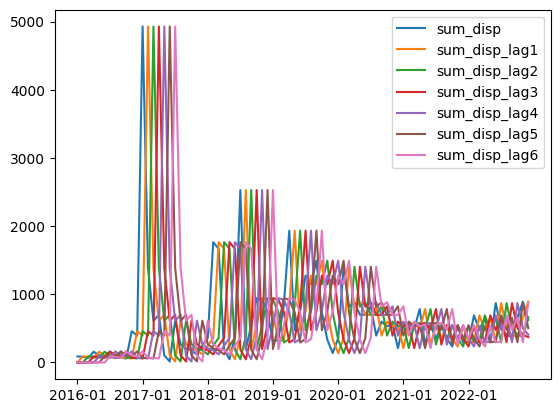

In [90]:
pl_1 = df_merged[df_merged['admin1']=='Awdal']

#plot TA, TA_lag1, .. against time in te same plot
fig, ax = plt.subplots()
ax.plot(pl_1['time'], pl_1['sum_disp'], label='sum_disp')
ax.plot(pl_1['time'], pl_1['sum_disp_lag1'], label='sum_disp_lag1')
ax.plot(pl_1['time'], pl_1['sum_disp_lag2'], label='sum_disp_lag2')
ax.plot(pl_1['time'], pl_1['sum_disp_lag3'], label='sum_disp_lag3')
ax.plot(pl_1['time'], pl_1['sum_disp_lag4'], label='sum_disp_lag4')
ax.plot(pl_1['time'], pl_1['sum_disp_lag5'], label='sum_disp_lag5')
ax.plot(pl_1['time'], pl_1['sum_disp_lag6'], label='sum_disp_lag6')
#change x axis to show only the years
ax.set_xticks(pl_1['time'][::12])
ax.legend()
plt.show()


## Normalization

In [81]:
col1=[ 'tmx', 'pre', 'conflicts', 
       'TA', 'TA_lag1', 'TA_lag2', 'TA_lag3', 'TA_lag4', 'TA_lag5', 'TA_lag6',  
       'PA', 'PA_lag1', 'PA_lag2', 'PA_lag3', 'PA_lag4', 'PA_lag5', 'PA_lag6', 
       'DL', 'DL_lag1', 'DL_lag2', 'DL_lag3', 'DL_lag4', 'DL_lag5', 'DL_lag6', 
        'conflicts_lag1', 'conflicts_lag2', 'conflicts_lag3',
       'conflicts_lag4', 'conflicts_lag5', 'conflicts_lag6',
       'sum_disp', 'sum_disp_lag1', 'sum_disp_lag2', 'sum_disp_lag3',
       'sum_disp_lag4', 'sum_disp_lag5', 'sum_disp_lag6', 
       'population_density', 'conflicts_log', 'sum_disp_log']

df_merged_norm = df_merged.copy()
min_max_scaler = MinMaxScaler().fit(df_merged_norm[col1])
df_merged_norm[col1] = min_max_scaler.transform(df_merged_norm[col1])

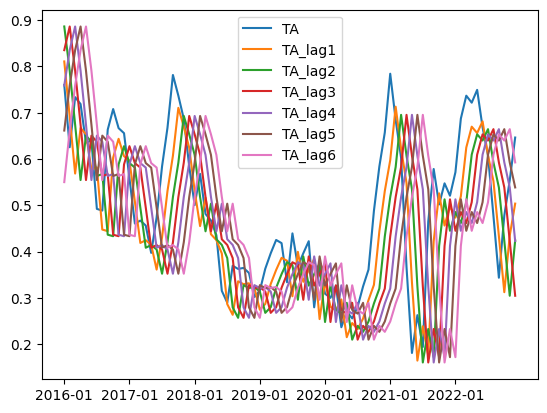

In [82]:
df_merged_norm[df_merged_norm['admin1']=='Awdal']
#plot TA, TA_lag1, .. against time in the same plot
pl = df_merged_norm[df_merged_norm['admin1']=='Awdal']
fig, ax = plt.subplots()
ax.plot(pl['time'], pl['TA'], label='TA')
ax.plot(pl['time'], pl['TA_lag1'], label='TA_lag1')
ax.plot(pl['time'], pl['TA_lag2'], label='TA_lag2')
ax.plot(pl['time'], pl['TA_lag3'], label='TA_lag3')
ax.plot(pl['time'], pl['TA_lag4'], label='TA_lag4')
ax.plot(pl['time'], pl['TA_lag5'], label='TA_lag5')
ax.plot(pl['time'], pl['TA_lag6'], label='TA_lag6')
#change x axis to show only the years
ax.set_xticks(pl['time'][::12])
ax.legend()
plt.show()


In [89]:
df_merged_norm.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_norm_log_d_lag.csv", index=False)

In [88]:
df_merged

,index,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,Bay,Galgaduud,Gedo,Hiraan,Lower_Juba,Lower_Shabelle,Middle_Juba,Middle_Shabelle,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi_Galbeed,sum_disp,year,month,TA,PA,DL,TA_lag1,TA_lag2,TA_lag3,TA_lag4,TA_lag5,TA_lag6,PA_lag1,PA_lag2,PA_lag3,PA_lag4,PA_lag5,PA_lag6,DL_lag1,DL_lag2,DL_lag3,DL_lag4,DL_lag5,DL_lag6,conflicts_lag1,conflicts_lag2,conflicts_lag3,conflicts_lag4,conflicts_lag5,conflicts_lag6,sum_disp_lag1,sum_disp_lag2,sum_disp_lag3,sum_disp_lag4,sum_disp_lag5,sum_disp_lag6,month_name,population_density,conflicts_log,sum_disp_log
0,1380,2016-01,Awdal,30.050001,3.775000,4.0,0.0,7.0,26.0,0.0,13.0,14.0,0.0,14.0,0.0,0.0,9.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,89.0,2016,01,1.928297,-0.380389,91,2.434686,2.849341,2.627356,2.296046,1.873843,1.390368,-0.327348,-0.319833,-0.188574,0.330028,0.632855,0.740946,90.0,89.0,88.0,87.0,86.0,85.0,4.0,6.0,9.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,141.666530,1.609438,4.499810
1,1380,2016-01,Bakool,34.450001,1.612500,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,01,1.763821,0.482869,91,1.788443,1.783297,1.522678,1.264791,0.911927,0.718079,0.451277,0.586344,0.556911,0.159646,0.164505,0.190000,90.0,89.0,88.0,87.0,86.0,85.0,8.0,4.0,2.0,12.0,7.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,103.529746,1.945910,0.000000
2,1380,2016-01,Banadir,33.189999,6.130000,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,01,0.945572,0.199790,12,0.863306,0.840679,0.722055,0.590230,0.336045,0.172140,0.142254,0.174271,0.135082,0.108746,0.125426,0.151867,11.0,10.0,9.0,8.0,7.0,6.0,33.0,42.0,34.0,30.0,33.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,6288.475825,3.610918,0.000000
3,1380,2016-01,Bari,29.037500,4.045833,6.0,0.0,0.0,23.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,31.0,2016,01,2.795625,0.105978,22,3.176745,3.343421,2.912430,2.351657,1.822589,1.519493,0.039772,0.236208,0.226168,0.240512,0.227770,0.050598,21.0,20.0,19.0,18.0,17.0,16.0,8.0,4.0,2.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,62.337389,1.945910,3.465736
4,1380,2016-01,Bay,34.357143,2.657143,16.0,0.0,14.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.0,2016,01,1.215753,0.388470,91,1.161052,1.146502,1.025850,0.854690,0.577776,0.467134,0.406663,0.562054,0.533465,0.168187,0.159837,0.183930,90.0,89.0,88.0,87.0,86.0,85.0,16.0,9.0,19.0,36.0,33.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,99.131867,2.833213,4.744932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,1463,2022-12,Nugaal,29.970005,3.780000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1378.0,0.0,0.0,0.0,0.0,1378.0,2022,12,0.242491,0.045570,2,0.000447,-0.100710,0.018210,0.843739,0.779011,0.677699,0.236927,0.262004,0.275457,0.262430,0.085265,0.069352,1.0,0.0,11.0,10.0,9.0,8.0,2.0,3.0,1.0,0.0,0.0,3.0,2374.0,1091.0,2151.0,431.0,446.0,501.0,NaN,23.889637,0.693147,7.229114
1508,1463,2022-12,Sanaag,27.188892,1.261111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465.0,0.0,0.0,0.0,465.0,2022,12,0.890553,0.055662,17,0.499523,0.236327,0.186017,1.232429,1.288775,1.293341,0.099197,0.107846,0.063488,0.065632,0.070942,0.072060,16.0,15.0,14.0,13.0,12.0,11.0,2.0,1.0,1.0,3.0,0.0,0.0,1126.0,2195.0,565.0,501.0,821.0,954.0,NaN,27.283836,0.000000,6.144186
1509,1463,2022-12,Sool,28.908335,0.441667,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170.0,0.0,0.0,514.0,0.0,0.0,684.0,2022,12,0.717894,0.046859,17,0.367086,0.116515,0.038315,0.970056,1.040620,1.101382,0.187917,0.205464,0.195224,0.181812,0.076649,0.068439,16.0,15.0,14.0,13.0,12.0,11.0,2.0,2.0,1.0,4.0,1.0,3.0,115.0,494.0,970.0,3569.0,592.0,6254.0,NaN,26.175893,2.197225,6.529419
1510,1463,2022-12,Togdheer,28.590000,0.770000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.0,0.0,0.0

In [84]:
#read csv
df_mer_1 = pd.read_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_norm_log_d.csv")
df_mer_1[df_mer_1['admin1']=='Awdal'].head()

,index,time,admin1,tmx,pre,conflicts,year,month,TA,PA,DL,TA_lag1,TA_lag2,TA_lag3,TA_lag4,TA_lag5,TA_lag6,PA_lag1,PA_lag2,PA_lag3,PA_lag4,PA_lag5,PA_lag6,DL_lag1,DL_lag2,DL_lag3,DL_lag4,DL_lag5,DL_lag6,conflicts_lag1,conflicts_lag2,conflicts_lag3,conflicts_lag4,conflicts_lag5,conflicts_lag6,month_name,yr_mth,Awdal,Bakool,Banadir,Bari,Bay,Galgaduud,Gedo,Hiraan,Lower_Juba,Lower_Shabelle,Middle_Juba,Middle_Shabelle,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi_Galbeed,sum_disp,population_density,conflicts_log,sum_disp_log
0,1380,2016-01,Awdal,0.291470,0.010244,0.041667,2016,1,0.760128,0.237045,0.522989,0.810713,0.886201,0.835072,0.758762,0.661518,0.550162,0.254084,0.256497,0.298663,0.465255,0.562534,0.597256,0.520231,0.517442,0.514620,0.511765,0.508876,0.505952,0.041667,0.062500,0.093750,0.062500,0.010417,0.010417,NaN,2016-01,0,7,26,0,13,14,0,14,0,0,9,0,0,6,0,0,0,0,0.000757,0.016448,0.351812,0.385427
18,1381,2016-02,Awdal,0.385817,0.052913,0.093750,2016,2,0.625460,0.360233,0.528736,0.691126,0.790695,0.886201,0.835072,0.758762,0.661518,0.237045,0.254084,0.256497,0.298663,0.465255,0.562534,0.526012,0.523256,0.520468,0.517647,0.514793,0.511905,0.041667,0.041667,0.062500,0.093750,0.062500,0.010417,NaN,2016-02,0,0,41,0,0,5,0,0,0,7,0,0,12,18,0,0,0,0,0.000706,0.016448,0.503329,0.379518
36,1382,2016-03,Awdal,0.654060,0.027743,0.020833,2016,3,0.733622,0.364569,0.534483,0.568683,0.674061,0.790695,0.886201,0.835072,0.758762,0.360233,0.237045,0.254084,0.256497,0.298663,0.465255,0.531792,0.529070,0.526316,0.523529,0.520710,0.517857,0.093750,0.041667,0.041667,0.062500,0.093750,0.062500,NaN,2016-03,39,0,16,0,0,0,0,7,0,0,0,0,4,0,0,0,0,0,0.000561,0.016448,0.240149,0.360149
54,1383,2016-04,Awdal,0.513463,0.261563,0.031250,2016,4,0.718720,0.562699,0.540230,0.667026,0.554641,0.674061,0.790695,0.886201,0.835072,0.364569,0.360233,0.237045,0.254084,0.256497,0.298663,0.537572,0.534884,0.532164,0.529412,0.526627,0.523810,0.020833,0.093750,0.041667,0.041667,0.062500,0.093750,NaN,2016-04,80,0,30,0,7,17,0,12,0,0,7,0,0,5,0,0,0,0,0.001344,0.016448,0.303034,0.434172
72,1384,2016-05,Awdal,0.596711,0.106974,0.031250,2016,5,0.635453,0.664635,0.545977,0.653477,0.650556,0.554641,0.674061,0.790695,0.886201,0.562699,0.364569,0.360233,0.237045,0.254084,0.256497,0.543353,0.540698,0.538012,0.535294,0.532544,0.529762,0.031250,0.020833,0.093750,0.041667,0.041667,0.062500,NaN,2016-05,11,0,36,8,6,20,0,8,0,0,0,0,0,16,0,0,0,0,0.000893,0.016448,0.303034,0.399443


In [85]:
#reset print options
df_merged.head()

,index,time,admin1,tmx,pre,conflicts,Awdal,Bakool,Banadir,Bari,Bay,Galgaduud,Gedo,Hiraan,Lower_Juba,Lower_Shabelle,Middle_Juba,Middle_Shabelle,Mudug,Nugaal,Sanaag,Sool,Togdheer,Woqooyi_Galbeed,sum_disp,year,month,TA,PA,DL,TA_lag1,TA_lag2,TA_lag3,TA_lag4,TA_lag5,TA_lag6,PA_lag1,PA_lag2,PA_lag3,PA_lag4,PA_lag5,PA_lag6,DL_lag1,DL_lag2,DL_lag3,DL_lag4,DL_lag5,DL_lag6,conflicts_lag1,conflicts_lag2,conflicts_lag3,conflicts_lag4,conflicts_lag5,conflicts_lag6,sum_disp_lag1,sum_disp_lag2,sum_disp_lag3,sum_disp_lag4,sum_disp_lag5,sum_disp_lag6,month_name,population_density,conflicts_log,sum_disp_log
0,1380,2016-01,Awdal,30.050001,3.775000,4.0,0.0,7.0,26.0,0.0,13.0,14.0,0.0,14.0,0.0,0.0,9.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,89.0,2016,01,1.928297,-0.380389,91,2.434686,2.849341,2.627356,2.296046,1.873843,1.390368,-0.327348,-0.319833,-0.188574,0.330028,0.632855,0.740946,90.0,89.0,88.0,87.0,86.0,85.0,4.0,6.0,9.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,141.666530,1.609438,4.499810
1,1380,2016-01,Bakool,34.450001,1.612500,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,01,1.763821,0.482869,91,1.788443,1.783297,1.522678,1.264791,0.911927,0.718079,0.451277,0.586344,0.556911,0.159646,0.164505,0.190000,90.0,89.0,88.0,87.0,86.0,85.0,8.0,4.0,2.0,12.0,7.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,103.529746,1.945910,0.000000
2,1380,2016-01,Banadir,33.189999,6.130000,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,01,0.945572,0.199790,12,0.863306,0.840679,0.722055,0.590230,0.336045,0.172140,0.142254,0.174271,0.135082,0.108746,0.125426,0.151867,11.0,10.0,9.0,8.0,7.0,6.0,33.0,42.0,34.0,30.0,33.0,49.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,6288.475825,3.610918,0.000000
3,1380,2016-01,Bari,29.037500,4.045833,6.0,0.0,0.0,23.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,31.0,2016,01,2.795625,0.105978,22,3.176745,3.343421,2.912430,2.351657,1.822589,1.519493,0.039772,0.236208,0.226168,0.240512,0.227770,0.050598,21.0,20.0,19.0,18.0,17.0,16.0,8.0,4.0,2.0,7.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,62.337389,1.945910,3.465736
4,1380,2016-01,Bay,34.357143,2.657143,16.0,0.0,14.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,114.0,2016,01,1.215753,0.388470,91,1.161052,1.146502,1.025850,0.854690,0.577776,0.467134,0.406663,0.562054,0.533465,0.168187,0.159837,0.183930,90.0,89.0,88.0,87.0,86.0,85.0,16.0,9.0,19.0,36.0,33.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,99.131867,2.833213,4.744932


## Displacements data manipulation

In [86]:
df_disp = df_disp[(df_disp['Reason']=='Drought related')]
df_disp['Current (Arrival) Region'] = df_disp['Current (Arrival) Region'].str.replace(' ', '_')
df_disp['Previous (Departure) Region'] = df_disp['Previous (Departure) Region'].str.replace(' ', '_')

In [87]:
v= df_disp["Month End"]
v=v.values
dt = [datetime.strptime(v[i], "%d/%m/%Y") for i in range(len(v))]
q=[]

for i in range(len(dt)):
    q.append(datetime.timestamp(dt[i]))
    
df_disp.insert(loc=3, column='date_timestamp', value=q)
df_disp = df_disp.sort_values("date_timestamp")

df_disp['Month End'] = pd.to_datetime(df_disp['Month End'], dayfirst=True)

TypeError: strptime() argument 1 must be str, not numpy.datetime64

In [ ]:
aggregated_data = df_disp.groupby([pd.Grouper(key='Month End', freq='M'),'Previous (Departure) Region', 'Current (Arrival) Region'])['Number of Individuals'].sum().to_frame()

# Get the unique values of 'Month End' and 'Previous (Departure) Region' 
dates = aggregated_data.index.get_level_values('Month End').unique()
districts = aggregated_data.index.get_level_values('Previous (Departure) Region').unique()

all_combinations = pd.MultiIndex.from_product([dates, districts, districts], names=['time', 'Previous (Departure) Region','Current (Arrival) Region'])

# Reindex the aggregated_data DataFrame with 'all_combinations'
disp_data = aggregated_data.reindex(all_combinations, fill_value=0).reset_index()   

In [ ]:
df_2016
#rename time column to match the one in disp_data
df_2016 = df_2016.rename(columns={'time': 'yr_mth'})

In [ ]:
disp_matxs = disp_data.pivot_table(index=['time','Current (Arrival) Region'], columns='Previous (Departure) Region', values='Number of Individuals', aggfunc='sum').reset_index()
disp_matxs = disp_matxs.rename(columns={'Current (Arrival) Region': 'admin1'})

#remove the day from the date
disp_matxs['yr_mth'] = disp_matxs['time'].map(lambda x: x.strftime('%Y-%m'))
disp_matxs = disp_matxs.drop(columns=['time'])
temp_pre_c['yr_mth'] = pd.to_datetime(temp_pre_c['time'], format='%Y-%m', dayfirst=True).map(lambda x: x.strftime('%Y-%m'))

df_merged = pd.merge(df_2016, disp_matxs, on=['yr_mth', 'admin1'], how='inner')

In [ ]:
df_2016

,yr_mth,admin1,tmx,pre,conflicts
0,1901-01,Awdal,29.000000,7.175000,NaN
1,1901-01,Bakool,33.437504,1.612500,NaN
2,1901-01,Banadir,32.549999,6.130000,NaN
3,1901-01,Bari,28.533331,4.045833,NaN
4,1901-01,Bay,33.478569,2.664286,NaN
...,...,...,...,...,...
26473,2023-07,Nugaal,NaN,NaN,0.0
26474,2023-07,Sanaag,NaN,NaN,0.0
26475,2023-07,Sool,NaN,NaN,2.0
26476,2023-07,Togdheer,NaN,NaN,1.0


In [ ]:
#add a column with the sum of the displacements
df_merged['sum_disp'] = df_merged.iloc[:, -18:].sum(axis=1)

In [ ]:
#df_merged.to_csv(r"/home/sara/Documenti/GitHub/Climate-and-conflict/csv/df_lags_2016_n4c_disp_d.csv", index=False)